# Chapter 09: Working with Unstructured Data

In today's data-driven world, companies are inundated with vast amounts of unstructured data, including documents, slides, emails, and more. Transforming this unstructured data into structured formats is crucial for unlocking its full potential. Leveraging LLMs enables businesses to efficiently convert unstructured information into datasets that can be stored in databases, CSV files, and other structured formats. This transformation not only facilitates data management but also allows for the training of machine learning models on the structured datasets. Ultimately, structured data can be seamlessly integrated into various workflows, functions, and processes, enabling more informed decision-making across the organization.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
from pathlib import Path
from pydantic import BaseModel, Field
from sklearn.metrics import accuracy_score
from language_models.models.llm import OpenAILanguageModel
from language_models.agent import (
    Agent,
    Workflow,
    WorkflowLLMStep,
    OutputType,
    PromptingStrategy,
)
from language_models.proxy_client import ProxyClient
from language_models.settings import settings

In [2]:
proxy_client = ProxyClient(
    client_id=settings.CLIENT_ID,
    client_secret=settings.CLIENT_SECRET,
    auth_url=settings.AUTH_URL,
    api_base=settings.API_BASE,
)

## Sentiment Analysis

For sentiment analysis of tweets, we can automate the process using an LLM to classify sentiment and store its reasoning. Instead of a chat-based application where users manually input tweets, the LLM can analyze tweets in bulk, classify sentiment, and record reasoning. Additionally, the LLM can extract properties such as tagged users and hashtags.

In [3]:
df_tweets = pd.read_csv("./assets/datasets/tweets.csv.gz", compression="gzip", encoding="latin-1", names=["sentiment", "id", "date", "query", "user", "tweet"])
df_tweets = df_tweets.dropna()
df_tweets = df_tweets.where(df_tweets.sentiment != 2)
df_tweets["sentiment"] = df_tweets["sentiment"].map({4: 1, 0: 0})
df_tweets_sampled = df_tweets.sample(20)
df_tweets_sampled.head()

,sentiment,id,date,query,user,tweet
288443,0,1994581755,Mon Jun 01 12:08:29 PDT 2009,NO_QUERY,shelsmonty,@JordansMyFix Damn... I wish you could go... ...
542800,0,2200554805,Tue Jun 16 19:03:28 PDT 2009,NO_QUERY,karlarosette,i don't feel good
579051,0,2213336412,Wed Jun 17 15:14:22 PDT 2009,NO_QUERY,Flor_G,I don't want to go to work today!! get out at...
687303,0,2251239719,Sat Jun 20 02:52:36 PDT 2009,NO_QUERY,_a_n_d_1_,I have to study
546463,0,2201766588,Tue Jun 16 20:44:35 PDT 2009,NO_QUERY,NDirishBelle,Bed....Have to wake up early for another day o...


In [4]:
system_prompt = """Take the following tweet and determine the sentiment of the review.

Respond with 1 (positive) or 0 (negative).

If you don't receive a tweet, respond with -1.

Additionally, provide the reason for your choice and extract all tagged users."""

llm = OpenAILanguageModel(
    proxy_client=proxy_client,
    model='gpt-4',
    max_tokens=500,
    temperature=0.2,
)

class Tweet(BaseModel):
    sentiment: int = Field(description="The sentiment of the tweet")
    reason: str = Field(description="The reason why you chose the sentiment")
    tagged: list[str] = Field(description="A list of people that are tagged, e.g. @user")

sentiment_analysis_agent = Agent.create(
    llm=llm,
    system_prompt=system_prompt,
    prompt="{tweet}",
    prompt_variables=["tweet"],
    output_type=OutputType.OBJECT,
    output_schema=Tweet,
    prompting_strategy=PromptingStrategy.SINGLE_COMPLETION,
    verbose=True,
)

In [5]:
def classify_sentiment(row) -> pd.Series:
    output = sentiment_analysis_agent.invoke({"tweet": row.tweet})
    sentiment = output.final_answer.sentiment or 0
    reason = output.final_answer.reason or ""
    tagged = output.final_answer.tagged or []
    sentiment_analysis_agent.chat.reset()
    return pd.Series([sentiment, reason, tagged], index=["prediction", "reason", "tagged"])

In [6]:
df_tweets_sampled[["prediction", "reason", "tagged"]] = df_tweets_sampled.apply(classify_sentiment, axis=1)

Final Answer: sentiment=0 reason='The user expresses disappointment that a certain person (@JordansMyFix) cannot attend an event, and they now have to find someone else.' tagged=['@JordansMyFix']
Final Answer: sentiment=0 reason="The user expressed a negative feeling by stating 'I don't feel good'." tagged=[]
Final Answer: sentiment=0 reason='The user is expressing a negative sentiment about not wanting to go to work and having to wake up early the next morning.' tagged=[]
Final Answer: sentiment=0 reason='The tweet is expressing a sense of obligation or duty, which can be interpreted as negative sentiment.' tagged=[]
Final Answer: sentiment=0 reason='The tweet expresses a negative sentiment because the user seems to be dreading waking up early for classes.' tagged=[]
Final Answer: sentiment=1 reason='The tweet is encouraging and friendly, suggesting a positive sentiment.' tagged=['@nessie111']
Final Answer: sentiment=1 reason="The user expresses positive emotions such as 'GREAT', 'LOV

In [7]:
df_tweets_sampled.head(20)

,sentiment,id,date,query,user,tweet,prediction,reason,tagged
288443,0,1994581755,Mon Jun 01 12:08:29 PDT 2009,NO_QUERY,shelsmonty,@JordansMyFix Damn... I wish you could go... ...,0,The user expresses disappointment that a certa...,[@JordansMyFix]
542800,0,2200554805,Tue Jun 16 19:03:28 PDT 2009,NO_QUERY,karlarosette,i don't feel good,0,The user expressed a negative feeling by stati...,[]
579051,0,2213336412,Wed Jun 17 15:14:22 PDT 2009,NO_QUERY,Flor_G,I don't want to go to work today!! get out at...,0,The user is expressing a negative sentiment ab...,[]
687303,0,2251239719,Sat Jun 20 02:52:36 PDT 2009,NO_QUERY,_a_n_d_1_,I have to study,0,The tweet is expressing a sense of obligation ...,[]
546463,0,2201766588,Tue Jun 16 20:44:35 PDT 2009,NO_QUERY,NDirishBelle,Bed....Have to wake up early for another day o...,0,The tweet expresses a negative sentiment becau...,[]
980719,1,1834046639,Mon May 18 01:25:22 PDT 2009,NO_QUERY,AreonLee,@nessie111 you should try!!! and while you're ...,1,"The tweet is encouraging and friendly, suggest...",[@nessie111]
1388215,1,2053006182,Sat Jun 06 02:54:00 PDT 2009,NO_QUERY,LiLYYBEE,had a GREAT day i LOVE going on DATES!!! firs...,1,The user expresses positive emotions such as '...,[]
231177,0,1978906653,Sun May 31 00:53:27 PDT 2009,NO_QUERY,milkaholic,it's summer and it's raining. geeezzzz i miss ...,0,The user seems to be upset about the rain in t...,[]
91385,0,1759495939,Sun May 10 19:20:25 PDT 2009,NO_QUERY,biscuit_and_tea,i am so bloody tired. tomorrow's school and im...,0,The user expresses negative feelings about bei...,[]
928570,1,1759619030,Sun May 10 19:36:45 PDT 2009,NO_QUERY,SusanCosmos,@silixell @unikeone @chavis_t @NancyEllyn @dud...,1,The user is expressing gratitude for the re-tw...,"[@silixell, @unikeone, @chavis_t, @NancyEllyn,..."


With an accuracy of 0.9, the performance is pretty good.

In [8]:
print(f"Accuracy: {accuracy_score(df_tweets_sampled.sentiment, df_tweets_sampled.prediction)}")

Accuracy: 0.9


## Drafting Contracts

When it comes to using LLMs to draft contracts, it's important to consider that contracts are often lengthy documents, sometimes spanning over 100 pages. This renders conversation-based applications impractical, as LLMs cannot generate such extensive documents, and users prefer not to interact directly with the LLM and manage its outputs themselves.

Here's a potential approach for an application to draft contracts: Rather than expecting the LLM to generate the entire document at once, we can break it down into manageable sections. Users could provide bullet points for each section, allowing the LLM to formulate the corresponding paragraphs. The application would then concatenate these outputs to create a document. Additionally, in practical scenarios, it's necessary to grant the LLM access to specific laws or legal references in some manner.

| Inputs |
|------|
| goal: string |
| section: string |
| context: string |

<br/>

| LLM that drafts a section |
|------|
| `Inputs` goal, section, context |
| `Output` draft: string |

<br/>

| LLM that refines the draft |
|------|
| `Inputs` draft |
| `Output` refine: string |

<br/>

| Output |
|------|
| refine: string |

First, we configure an LLM to draft detailed sections. We provide specific instructions and context to guide the AI in generating these drafts.

In [9]:
system_prompt = """Your primary task is to draft very detailed sections of contracts, ensuring they align with regulations.

Only write about the section name you will receive and do not write any information outside of that."""

prompt = """Overall goal: {goal}

Section name: {section}
Consider this context:
{context}"""

llm = OpenAILanguageModel(
    proxy_client=proxy_client,
    model='gpt-4',
    max_tokens=4000,
    temperature=0.2,
)

draft_contract_section = Agent.create(
    llm=llm,
    system_prompt=system_prompt,
    prompt=prompt,
    prompt_variables=["goal", "section", "context"],
    output_type=OutputType.STRING,
    prompting_strategy=PromptingStrategy.SINGLE_COMPLETION,
    verbose=True,
)

Then, we use another LLM to refine contract sections, ensuring compliance with regulations and including relevant references. We provide the draft and context to guide the AI in enhancing the contract section.

In [10]:
system_prompt = """You are tasked with refining contract sections.

Where regulations are applied, include the references."""

prompt = """Overall goal: {goal}

Section name: {section}
Draft:
{draft}"""

llm = OpenAILanguageModel(
    proxy_client=proxy_client,
    model='gpt-4-32k',
    max_tokens=4000,
    temperature=0.2,
)

refine_contract_section = Agent.create(
    llm=llm,
    system_prompt=system_prompt,
    prompt=prompt,
    prompt_variables=["goal", "section", "draft"],
    output_type=OutputType.STRING,
    prompting_strategy=PromptingStrategy.SINGLE_COMPLETION,
    verbose=True,
)

Next, we create a workflow to generate and refine contract sections using LLMs. We provide the goal and context as inputs, then process these through steps for drafting and refining the section.

In [11]:
class Inputs(BaseModel):
    goal: str = Field(description="The contract the user wants to draft")
    section: str = Field(description="The title section")
    context: str = Field(description="The context provided for a section as bullet points")

workflow = Workflow(
    name="Generates a contract section",
    description="Uses LLMs to generate a contract section given some context",
    inputs=Inputs,
    output="refine",
    steps=[
        WorkflowLLMStep(name="draft", agent=draft_contract_section),
        WorkflowLLMStep(name="refine", agent=refine_contract_section),
    ]
)

The following shows the different sections that we want to include.

In [12]:
goal = """Draft a contract for the development, procurement, and maintenance of weapons systems,
namely unmanned aerial vehicles, between ABC Inc (referred to as employee)
and XYZ referred to as employer. Provide information about the background,
Applicable Documents, Requirements, Security."""

class ContractSection(BaseModel):
    title: str
    context: str

scope_of_work = ContractSection(
    title="Scope of Work",
    context="""The Contractor shall provide all personnel, equipment, materials, and facilities necessary to design, develop, manufacture, test, deliver, and maintain the UAV systems.

The scope includes:
- Design & Development:
- Procurement & Manufacturing:
- Maintenance & Support:
- Training & Documentation:""",
)

technical_requirements = ContractSection(
    title="Technical Requirements",
    context="""The technical requirements should include:
- Design Specifications:
- Software Development:
- System Integration:""",
)

delivery_requirements = ContractSection(
    title="Delivery Requirements",
    context="""The delivery requirements should include:
- Production Schedule:
- Quality Assurance:""",
)

maintenance_requirements = ContractSection(
    title="Maintenance Requirements",
    context="""The maintenance requirements should include:
- Maintenance Services:
- Spare Parts:""",
)

security_requirements = ContractSection(
    title="Security Requirements",
    context="""Compliance with cybersecurity and protection plans, etc.

The security requirements should include:
- Security Classification:
- Facility Security:""",
)

cybersecurity_requirements = ContractSection(
    title="Cybersecurity Requirements",
    context="""Compliance with cybersecurity and protection plans, etc.

The cybersecurity requirements should include:
- Incident Reporting:""",
)

period_of_performance = ContractSection(
    title="Period of Performance",
    context="""This section should include:
- Start and End Dates: Clearly specify the contract start date (e.g., "Commencement of work on [Start Date]") and the expected completion date (e.g., "Completion of all contractual obligations by [End Date]"), ensuring alignment with project milestones and deliverables.
- Milestone Deadlines: Outline critical milestone dates within the period of performance, including deadlines for design reviews, prototype delivery, testing phases, and final system delivery, to ensure progress is tracked and managed effectively.
- Options for Extension: Include provisions for possible extensions or modifications of the period of performance, detailing the process and conditions under which the contract duration may be extended (e.g., unforeseen delays, additional work requirements).""",
)

payment_and_funding = ContractSection(
    title="Payment and Funding",
    context="""This section should include:
- Contract Value:
- Payment Schedule:
- Funding Obligations:""",
)

contract_administration = ContractSection(
    title="Contract Administration",
    context="""This section should include:
- Contracting Officer Responsibilities: Identify the designated Contracting Officer (CO) from the employer, outlining their authority to administer the contract, make decisions, issue modifications, and handle any formal communications between the employer and the Contractor.
- Contractor Point of Contact: Specify the primary point of contact (POC) from ABC Inc., responsible for managing contract performance, responding to CO inquiries, and ensuring timely submission of required deliverables and reports.
- Record-Keeping and Reporting Requirements: Detail the procedures for maintaining and submitting records related to contract performance, including regular status reports, financial documentation, and compliance records, ensuring they meet the standards set by applicable regulations."""
)

disputes = ContractSection(
    title="Disputes",
    context="""This section should include:
- Dispute Resolution Process: Outline the step-by-step process for resolving disputes, including initial negotiation efforts, escalation procedures, and potential use of alternative dispute resolution (ADR) methods like mediation or arbitration before resorting to litigation.
- Governing Law and Jurisdiction: Specify the applicable law governing the contract (e.g., the law of the country or region) and the jurisdiction or venue where disputes will be adjudicated.
- Timelines for Filing Claims: Define the timeframes within which disputes must be raised and resolved, including deadlines for filing formal claims, submitting responses, and completing the dispute resolution process to prevent delays in contract performance."""
)

termination = ContractSection(
    title="Termination",
    context="""This section should include:
- Termination for Convenience: Specify the conditions under which either party may terminate the contract for convenience, including the required notice period (e.g., 30 days) and any obligations for settling outstanding payments and deliverables upon termination.
- Termination for Cause: Outline the circumstances that allow termination for cause, such as failure to perform contractual obligations, non-compliance with terms, or breach of contract. Include the procedures for notifying the offending party, providing opportunities to cure breaches, and the process for formal termination.
- Settlement of Accounts: Detail the procedures for the settlement of accounts upon termination, including the return of any employer-furnished property, final payments for work performed up to the termination date, and any adjustments for partially completed work or costs incurred."""
)

signatures = ContractSection(
    title="Signatures",
    context="""This section should include:
- Authorized Signatures: Ensure that the contract is signed by authorized representatives from both XYZ and ABC Inc., including the names, titles, and dates of signing, along with any required witness signatures."""
)

contract_sections = [
    scope_of_work,
    technical_requirements,
    delivery_requirements,
    maintenance_requirements,
    security_requirements,
    cybersecurity_requirements,
    period_of_performance,
    payment_and_funding,
    contract_administration,
    disputes,
    termination,
    signatures,
]


Now, we can generate a contract based on the information we provided.

In [13]:
def generate_contract(goal: str, contract_sections: list[ContractSection]) -> str:
    content = []
    for contract_section in contract_sections:
        output = workflow.invoke({
            "goal": goal,
            "section": contract_section.title,
            "context": contract_section.context,
        })
        content.append(output.output)
    return "\n\n".join(content)

In [14]:
contract = generate_contract(goal, contract_sections)

Use LLM: draft
Inputs: {'goal': 'Draft a contract for the development, procurement, and maintenance of weapons systems,\nnamely unmanned aerial vehicles, between ABC Inc (referred to as employee)\nand XYZ referred to as employer. Provide information about the background,\nApplicable Documents, Requirements, Security.', 'section': 'Scope of Work', 'context': 'The Contractor shall provide all personnel, equipment, materials, and facilities necessary to design, develop, manufacture, test, deliver, and maintain the UAV systems.\n\nThe scope includes:\n- Design & Development:\n- Procurement & Manufacturing:\n- Maintenance & Support:\n- Training & Documentation:'}
Prompt: Overall goal: Draft a contract for the development, procurement, and maintenance of weapons systems,
namely unmanned aerial vehicles, between ABC Inc (referred to as employee)
and XYZ referred to as employer. Provide information about the background,
Applicable Documents, Requirements, Security.

Section name: Scope of Work

In [15]:
print(contract)

Section: Scope of Work

1. Design & Development: The Contractor, ABC Inc., shall be responsible for the design and development of the unmanned aerial vehicles (UAVs) in accordance with the Federal Aviation Administration (FAA) regulations (14 CFR Part 107). This includes, but is not limited to, conceptualization, drafting, prototyping, and finalizing the design of the UAV systems. The Contractor shall also be responsible for the development of the UAV systems, which includes the creation of the software and hardware components, integration of the systems, and testing of the UAV systems to ensure they meet the specifications and requirements set forth by the Employer, XYZ.

2. Procurement & Manufacturing: The Contractor shall be responsible for the procurement of all necessary materials, equipment, and technologies required for the manufacturing of the UAV systems, adhering to the Defense Federal Acquisition Regulation Supplement (DFARS). This includes sourcing and purchasing from relia

## Generating Machine Learning Code

Consider using an AI agent to generate machine learning code. Initially, you might think to give the LLM a piece of the dataset to generate the code. But this simple idea might not work well. The LLM could make mistakes, like treating a classification task as a regression because of how the classes are represented numerically.

To fix this, you could have the LLM figure out the problem type first, using insights from the dataset and prompts from the user, before generating any code. While this sounds doable with just one agent, it actually makes things more complicated when it comes to formatting the output. To make things simpler, it's better to split the AI agent into two parts that work together. The 1st LLM looks at the dataset and problem description to figure out what kind of machine learning problem it is, like classification. Then, the 2nd LLM uses this info to generate machine learning code. This split not only makes things easier for the LLMs but also helps humans understand the structure more easily. It also simplifies the process of adjusting the prompts to ensure that the LLM only responds with code.

| Inputs |
|------|
| problem description: string |
| dataset size: integer |
| dataset schema: string |
| dataset snippet: string |

<br/>

| LLM that determines the machine learning problem |
|------|
| `Inputs` problem description, dataset size, dataset schema |
| `Output` modeling problem: string |

<br/>

| LLM that generates machine learning code |
|------|
| `Inputs` modeling problem, dataset size, dataset schema, dataset snippet |
| `Output` code: string |

<br/>

| Output |
|------|
| code: string |

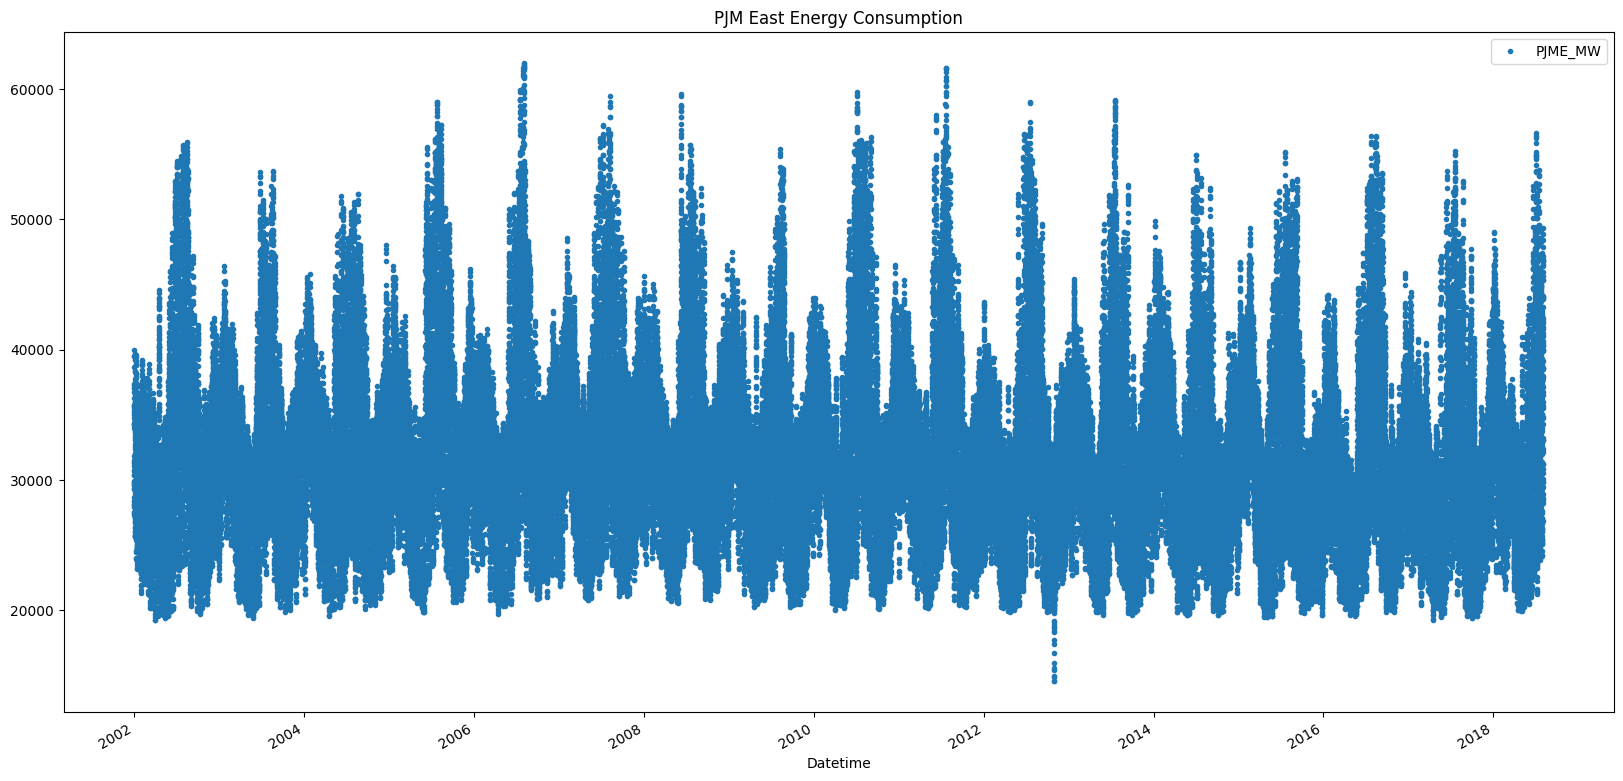

In [16]:
df = pd.read_csv("./assets/datasets/energy_consumption.csv", parse_dates=[0])
df.plot(x="Datetime", y="PJME_MW", style=".", figsize=(20, 10), title="PJM East Energy Consumption")
plt.show()

In [17]:
system_prompt = """You are a Data Science agent, which helps the user solve machine learning problems.

Respond with 1 of the following machine learning problems:
- Classification
- Regression
- Clustering
- Time series forecasting"""

prompt = """Choose the machine learning problem best suited for the following problem and dataset.

Problem description:
{problem_description}

Dataset:
Number of rows: {dataset_size}
Schema:
{dataset_schema}"""

llm = OpenAILanguageModel(
    proxy_client=proxy_client,
    model='gpt-4',
    max_tokens=250,
    temperature=0.2,
)

problem_finder_agent = Agent.create(
    llm=llm,
    system_prompt=system_prompt,
    prompt=prompt,
    prompt_variables=["problem_description", "dataset_size", "dataset_schema"],
    output_type=OutputType.STRING,
    prompting_strategy=PromptingStrategy.SINGLE_COMPLETION,
    verbose=True,
)

In [18]:
system_prompt = """You are a Data Science agent, which helps the user solve machine learning problems.

You can solve machine learning problems for:
- Classification
- Regression
- Clustering
- Time series forecasting

You have access to the following Python libraries:
- pandas
- numpy
- scikit-learn
- fbprophet"""

prompt = """Given the following machine learning problem, respond with Python code.

Only write Python code and do not respond with other information.

Modeling problem: {modeling_problem}

Dataset:
Number of rows: {dataset_size}
Schema:
{dataset_schema}
First 10 rows of dataset:
{dataset_snippet}"""

llm = OpenAILanguageModel(
    proxy_client=proxy_client,
    model='gpt-4-32k',
    max_tokens=2000,
    temperature=0.2,
)

ml_agent = Agent.create(
    llm=llm,
    system_prompt=system_prompt,
    prompt=prompt,
    prompt_variables=["modeling_problem", "dataset_size", "dataset_schema", "dataset_snippet"],
    output_type=OutputType.STRING,
    prompting_strategy=PromptingStrategy.SINGLE_COMPLETION,
    verbose=True,
)

In [19]:
class MLCodeGeneration(BaseModel):
    problem_description: str = Field(description="The user problem")
    dataset_size: int = Field(description="Size of the dataset")
    dataset_schema: str = Field(description="Schema of the dataset")
    dataset_snippet: str = Field(description="Snippet of the dataset")

ml_workflow = Workflow(
    name="Generate Machine Learning Code",
    description="Allows you to generate ML code",
    inputs=MLCodeGeneration,
    output="code",
    steps=[
        WorkflowLLMStep(name="modeling_problem", agent=problem_finder_agent),
        WorkflowLLMStep(name="code", agent=ml_agent)
    ],
)

In [20]:
info_str = StringIO()
df.info(buf=info_str)
dataset_schema = info_str.getvalue()

In [21]:
output = ml_workflow.invoke({
    "problem_description": "I want to forecast hourly energy use.",
    "dataset_size": len(df),
    "dataset_schema": dataset_schema,
    "dataset_snippet": str(df.head(10).to_markdown())
})

Use LLM: modeling_problem
Inputs: {'problem_description': 'I want to forecast hourly energy use.', 'dataset_size': 145366, 'dataset_schema': "<class 'pandas.core.frame.DataFrame'>\nRangeIndex: 145366 entries, 0 to 145365\nData columns (total 2 columns):\n #   Column    Non-Null Count   Dtype         \n---  ------    --------------   -----         \n 0   Datetime  145366 non-null  datetime64[ns]\n 1   PJME_MW   145366 non-null  float64       \ndtypes: datetime64[ns](1), float64(1)\nmemory usage: 2.2 MB\n"}
Prompt: Choose the machine learning problem best suited for the following problem and dataset.

Problem description:
I want to forecast hourly energy use.

Dataset:
Number of rows: 145366
Schema:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  145366 non-null  datetime64[ns]
 1   PJME_MW   145366 non-null  float64   

In [22]:
print(output.output)

```python
import pandas as pd
from fbprophet import Prophet

# Assuming the data is in a DataFrame df
df.columns = ['ds', 'y']  # rename the columns to the names expected by Prophet

model = Prophet()
model.fit(df)

# Make future dataframe for prediction
future = model.make_future_dataframe(periods=365)  # assuming we want to forecast for the next 365 days

forecast = model.predict(future)

# If you want to plot the forecast
# model.plot(forecast)
```


Or we can let the LLM write code to train a classifier for analyzing the sentiment of tweets.

In [23]:
df_tweets.head()

,sentiment,id,date,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [24]:
info_str = StringIO()
df_tweets.info(buf=info_str)
dataset_schema = info_str.getvalue()

In [25]:
output = ml_workflow.invoke({
    "problem_description": "I want to classify the sentiment of tweets.",
    "dataset_size": len(df_tweets),
    "dataset_schema": dataset_schema,
    "dataset_snippet": str(df_tweets.head(10).to_markdown())
})

Use LLM: modeling_problem
Inputs: {'problem_description': 'I want to classify the sentiment of tweets.', 'dataset_size': 1600000, 'dataset_schema': "<class 'pandas.core.frame.DataFrame'>\nRangeIndex: 1600000 entries, 0 to 1599999\nData columns (total 6 columns):\n #   Column     Non-Null Count    Dtype \n---  ------     --------------    ----- \n 0   sentiment  1600000 non-null  int64 \n 1   id         1600000 non-null  int64 \n 2   date       1600000 non-null  object\n 3   query      1600000 non-null  object\n 4   user       1600000 non-null  object\n 5   tweet      1600000 non-null  object\ndtypes: int64(2), object(4)\nmemory usage: 73.2+ MB\n"}
Prompt: Choose the machine learning problem best suited for the following problem and dataset.

Problem description:
I want to classify the sentiment of tweets.

Dataset:
Number of rows: 1600000
Schema:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Coun

In [26]:
print(output.output)

```python
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

# Assuming the data is in a DataFrame df
X = df['tweet']
y = df['sentiment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the text data into a matrix of token counts
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

# Train a logistic regression model
clf = LogisticRegression()
clf.fit(X_train_counts, y_train)

# Predict the sentiment for the test data
y_pred = clf.predict(X_test_counts)

# If you want to calculate the accuracy of the model
# from sklearn.metrics import accuracy_score
# accuracy = accuracy_score(y_test, y_pred)
```


## Comparing Jobs

When comparing two job descriptions, one approach involves presenting both job postings to an LLM to identify similarities and differences. However, this method may not yield optimal results, as job descriptions often include non-essential information such as "equal employment opportunity" statements. To address this, we can deconstruct the problem by initially tasking an LLM to extract relevant data from each job description. In our case 2 instances as we are comparing 2 jobs. Subsequently, this condensed information can be inputted into a 3rd LLM, tasked with analyzing the extracted data to identify differences and similarities between the two jobs.

| Inputs |
|------|
| job 1: string |
| job 2: string |

<br/>

| LLM that extracts job data |
|------|
| `Inputs` job 1 |
| `Output` job 1: Job(title: string, duties: string, salary: list[string]) |

<br/>

| LLM that extracts job data |
|------|
| `Inputs` job 2 |
| `Output` job 2: Job(title: string, duties: string, salary: list[string]) |

<br/>

| LLM that compares 2 jobs |
|------|
| `Inputs` job 1, job 2 |
| `Output` job comparison: JobComparison(differences: string, similarities: string) |

<br/>

| Output |
|------|
| job comparison: JobComparison(differences: string, similarities: string) |

In [27]:
def get_job(path: str) -> str:
    with open(path, "r", encoding="utf-8") as file:
        content = file.read()
        return content

job1 = get_job("./assets/datasets/jobs/ELECTRICAL ENGINEERING ASSOCIATE 7525 093016 REV 100416.txt")
job2 = get_job("./assets/datasets/jobs/ELECTRICAL MECHANIC 3841 012017.txt")

In this step, LLMs are responsible for extracting information from two different job descriptions. The LLM processes the details and outputs them as a `Job` object, encapsulating key information like job title, responsibilities, and requirements.

In [28]:
system_prompt = "Take the following job and extract data about the job"

llm = OpenAILanguageModel(
    proxy_client=proxy_client,
    model='gpt-4',
    max_tokens=1000,
    temperature=0.2,
)

class Job(BaseModel):
    title: str = Field(description="The job title.")
    duties: str = Field(description="The duties of the job.")
    salary: list[str] = Field(description="A list of salary ranges. Format: 'min salary to max salary'.")

job_agent1 = Agent.create(
    llm=llm,
    system_prompt=system_prompt,
    prompt="{job1}",
    prompt_variables=["job1"],
    output_type=OutputType.OBJECT,
    output_schema=Job,
    prompting_strategy=PromptingStrategy.SINGLE_COMPLETION,
    verbose=True,
)

job_agent2 = Agent.create(
    llm=llm,
    system_prompt=system_prompt,
    prompt="{job2}",
    prompt_variables=["job2"],
    output_type=OutputType.OBJECT,
    output_schema=Job,
    prompting_strategy=PromptingStrategy.SINGLE_COMPLETION,
    verbose=True,
)

In this step, the LLM is responsible for comparing the two jobs. Since we outputted a `Job` object from the previous step, we can easily use dot notation to access and compare specific properties, such as `Job.title`, `Job.duties`, and `Job.salary`.

In [29]:
system_prompt = "Take the following 2 job descriptions and respond with the similarities and differences of the jobs."

prompt = """Compare the 2 given job descriptions:

Job 1:
Job title: {job1.title}
Job duties:
{job1.duties}
Salary:
{job1.salary}

Job 2:
Job title: {job2.title}
Job duties:
{job2.duties}
Salary:
{job2.salary}"""

llm = OpenAILanguageModel(
    proxy_client=proxy_client,
    model='gpt-4',
    max_tokens=1000,
    temperature=0.2,
)

class JobComparison(BaseModel):
    similarities: str = Field(description="The job similarities.")
    differences: str = Field(description="The job differences.")

job_comparison_agent = Agent.create(
    llm=llm,
    system_prompt=system_prompt,
    prompt=prompt,
    prompt_variables=["job1", "job2"],
    output_type=OutputType.OBJECT,
    output_schema=JobComparison,
    prompting_strategy=PromptingStrategy.SINGLE_COMPLETION,
    verbose=True,
)

Now, we can create a workflow that compares 2 jobs.

In [30]:
class CompareJobs(BaseModel):
    job1: str = Field(description="The first job")
    job2: str = Field(description="The second job")

workflow = Workflow(
    name="Compare Jobs",
    description="Allows you to compare key information of 2 jobs",
    inputs=CompareJobs,
    output="job_comparison",
    steps=[
        WorkflowLLMStep(name="job1", agent=job_agent1),
        WorkflowLLMStep(name="job2", agent=job_agent2),
        WorkflowLLMStep(name="job_comparison", agent=job_comparison_agent),
    ],
)

In [31]:
output = workflow.invoke({"job1": job1, "job2": job2})

Use LLM: job1
Inputs: {'job1': 'ELECTRICAL ENGINEERING ASSOCIATE\nClass Code:       7525\nOpen Date:  09-30-16\nREVISED: 10-04-16\n (Exam Open to All, including Current City Employees)\nANNUAL SALARY \n\n$66,231 to $94,252; $74,082 to $105,444; $82,497 to $117,346; and $89,638 to $127,556\nThe salary in the Department of Water and Power is $77,360 to $96,110; $91,934 to $114,213; $99,722 to $123,881; and $107,156 to \n$133,130\n\nNOTES:\n\n1. Candidates from the eligible list are normally appointed to vacancies in the lower pay grade positions.\n2. For information regarding reciprocity between City of Los Angeles departments and LADWP, go to: http://per.lacity.org/Reciprocity_CityDepts_and_DWP.pdf.\n3. The current salary range is subject to change. You may confirm the starting salary with the hiring department before accepting a job offer.\n\nDUTIES\n\nAn Electrical Engineering Associate performs professional electrical engineering work in the preparation of designs, plans, specificati

In [32]:
print(output.output.similarities)

Both jobs are related to the field of electrical engineering and involve working with electrical systems and equipment. They both require knowledge of installation and maintenance of electrical circuits and related equipment. Both jobs also involve work in various facilities and buildings.


In [33]:
print(output.output.differences)

The Electrical Engineering Associate is more focused on design, planning, specifications, economic and cost analysis, contracts, and reports for electrical systems and equipment. They may also perform code enforcement functions relating to designs and specifications of electrical installations and equipment approval. The Electrical Mechanic, on the other hand, is more hands-on and performs skilled mechanical and electrical work in the installation and maintenance of high and low voltage electrical circuits and related equipment at electrical stations and plants. They may work at heights, near hazardous materials, and in confined spaces. The salary range also differs for both jobs.


## Transforming Unstructured Data into Structured Formats

An excellent application of LLMs involves organizing unstructured data, such as text documents. Take, for instance, a collection of job descriptions. While there are various methods to tackle this task, like coding a parser or using optical character recognition, we opt to leverage an LLM for the job. Initially, we define the specific information we wish to extract from the job postings, such as the job title, salary, application instructions, and more. The LLM then looks at each job description and extracts the details for us. Subsequently, we can store this dataset as a CSV file for further analysis and use.

In [29]:
path = Path("./assets/datasets/jobs")
filenames = [file.name for file in path.iterdir() if file.is_file()]
jobs = []
for filename in filenames:
    file_path = path / filename
    with open(file_path, "r", encoding="utf-8", errors="replace") as file:
        content = file.read()
        jobs.append(content)

In [30]:
system_prompt = """Take the following job and extract data about the job.

Respond with the job information:
- job title: title of the job.
- job class no: class number as an integer.
- job duties: duties of the job.
- open date: when the position was created. Use DD-MM-YYYY.
- salary: the salary ranges.
- deadline: when the application deadline is. Use DD-MM-YYYY.
- application form: online or email or fax.
- where to apply: url or location."""

llm = OpenAILanguageModel(
    proxy_client=proxy_client,
    model='gpt-4-32k',
    max_tokens=4000,
    temperature=0.2,
)

class Salary(BaseModel):
    description: str = Field(description="The description of the level")
    min_salary: float = Field(description="The minimum salary for this position or level")
    max_salary: float = Field(description="The maximum salary for this position or level")

class Job(BaseModel):
    job_title: str = Field(description="The job title.")
    job_class_no: int = Field(description="The job class number as an integer.")
    job_duties: str = Field(description="The duties of the job.")
    open_date: str = Field(description="When the position was opened. Format: DD-MM-YYYY.")
    salary: list[Salary] = Field(description="A list of salary ranges. Format: 'min salary to max salary'.")
    deadline: str = Field(description="The application deadline. Format: DD-MM-YYYY")
    application_form: str = Field(description="The form of the application (e.g. online, fax, email).")
    where_to_apply: str = Field(description="The url to apply at or location to send the fax or email address.")

job_data_agent = Agent.create(
    llm=llm,
    system_prompt=system_prompt,
    prompt="{job}",
    prompt_variables=["job"],
    output_type=OutputType.STRUCT,
    output_schema=Job,
    prompting_strategy=PromptingStrategy.CHAIN_OF_THOUGHT,
    verbose=True,
)

Now, we can create our dataset containing 683 jobs.

In [31]:
def extract_jobs(jobs: list[str]) -> pd.DataFrame:
    data = []
    for job in jobs:
        output = job_data_agent.invoke({"job": job})
        output.final_answer["text"] = job
        data.append(output.final_answer)
        job_data_agent.chat.reset()
    return pd.DataFrame(data)

In [32]:
df_jobs = extract_jobs(jobs)

Thought: The job information is spread throughout the text. I will start by identifying the job title, class number, open date, salary range, job duties, application deadline, application form, and where to apply. Then, I will format these into a JSON object.
Final Answer: {'job_title': 'SENIOR HOUSING INSPECTOR', 'job_class_no': 4244, 'job_duties': 'A Senior Housing Inspector supervises employees engaged either in the inspection of residential rental property locations for conformance to housing habitability, quality, and property maintenance ordinances; or in the investigation of code violation complaints and the following through with the code enforcement process by way of litigation or administrative abatement; and personally conducts the more difficult field inspections.', 'open_date': '27-04-2018', 'salary': [{'description': 'Annual salary', 'min_salary': 90410.0, 'max_salary': 109306.0}], 'deadline': '10-05-2018', 'application_form': 'online', 'where_to_apply': 'https://www.gove

In [33]:
df_jobs.head()

,job_title,job_class_no,job_duties,open_date,salary,deadline,application_form,where_to_apply,text
0,SENIOR HOUSING INSPECTOR,4244,A Senior Housing Inspector supervises employee...,27-04-2018,"[{'description': 'Annual salary', 'min_salary'...",10-05-2018,online,https://www.governmentjobs.com/careers/lacity/...,SENIOR HOUSING INSPECTOR\n\nClass Code: ...
1,Legislative Assistant,1182,A Legislative Assistant serves one or more Cou...,18-09-2015,"[{'description': 'Salary Range 1', 'min_salary...",01-10-2015,online,http://agency.governmentjobs.com/lacity/defaul...,LEGISLATIVE ASSISTANT\nClass Code: 1182\...
2,District Supervisor Animal Services,4320,A District Supervisor Animal Services (Distric...,23-02-2018,"[{'description': 'Annual salary', 'min_salary'...",08-03-2018,online,https://www.governmentjobs.com/careers/lacity/...,DISTRICT SUPERVISOR ANIMAL SERVICES\n(Class Ti...
3,LEGISLATIVE REPRESENTATIVE,9482,A Legislative Representative represents the Ha...,29-12-2017,"[{'description': 'General Salary', 'min_salary...",11-01-2018,online,https://www.governmentjobs.com/careers/lacity,LEGISLATIVE REPRESENTATIVE\nClass Code: ...
4,Gallery Attendant,2442,A Gallery Attendant assists in the constructio...,25-09-2015,"[{'description': 'Annual Salary', 'min_salary'...",08-10-2015,online,http://agency.governmentjobs.com/lacity/defaul...,GALLERY ATTENDANT \nClass Code: 2442\nOp...


In [34]:
df_jobs.to_csv("./assets/datasets/jobs.csv", index=False)

The LLM performed flawlessly, demonstrating strong consistency in generating structured outputs without making any mistakes.

In [35]:
df_jobs.isna().sum()

job_title           0
job_class_no        0
job_duties          0
open_date           0
salary              0
deadline            0
application_form    0
where_to_apply      0
text                0
dtype: int64